In [1]:
# ignore this
%load_ext music21.ipython21

## User's Guide, Chapter 19: Advanced Durations (Complex, Ties, and Tuplets)

When last we encountered the :class:`~music21.duration.Duration` object, it was Chapter 3, and we didn't know about Streams or any of a thousand other cool things that are now under our belts, so it seems a good idea to get back to Duration objects and look in a bit more depth at how they work.

We'll recall that one thing that all `Music21Objects` have a `Duration` object stored on their `.duration` attributes:

In [2]:
n = note.Note('C#4')
n.duration

<music21.duration.Duration 1.0>

...and that durations can be created directly:

In [3]:
d = duration.Duration(4.0)
d

<music21.duration.Duration 4.0>

...and that all durations have `.type`, `.dots`, and `.quarterLength`.

In [4]:
d = duration.Duration(1.5)
(d.type, d.dots, d.quarterLength)

('quarter', 1, 1.5)

The standard `type` values range from tiny 2048th notes up through the immense duplex-maxima:

In [5]:
startType = '2048th'
try:
    while True:
        print(startType, end=", ")
        startType = duration.nextLargerType(startType)
except duration.DurationException:
    pass

2048th, 1024th, 512th, 256th, 128th, 64th, 32nd, 16th, eighth, quarter, half, whole, breve, longa, maxima, duplex-maxima, 

The number of dots is limited only by your own imagination (or the limit of expressibility of your computer):

In [6]:
for dots in range(12):
    print(dots, duration.Duration(type='quarter', dots=dots))

0 <music21.duration.Duration 1.0>
1 <music21.duration.Duration 1.5>
2 <music21.duration.Duration 1.75>
3 <music21.duration.Duration 1.875>
4 <music21.duration.Duration 1.9375>
5 <music21.duration.Duration 1.96875>
6 <music21.duration.Duration 1.984375>
7 <music21.duration.Duration 1.9921875>
8 <music21.duration.Duration 1.99609375>
9 <music21.duration.Duration 1.998046875>
10 <music21.duration.Duration 1.9990234375>
11 <music21.duration.Duration 1.99951171875>


A lot of Duration values can be expressed with all these types and dots, but not all of them.  We can get some more by moving on to Tuplets.

## Tuplets

Tuplets, such as triplets, can be set by giving a fraction or close approximation to a fraction as a quarter length:

In [7]:
d = duration.Duration(0.3333333333333)
d

<music21.duration.Duration 1/3>

The quarterLength of a duration such as this will be expresssed as a `fractions.Fraction` class:

In [8]:
d.quarterLength

Fraction(1, 3)

This can be converted to a floating point approximate representation by wrapping it in the `float()` function:

In [9]:
float(d.quarterLength)

0.3333333333333333

We can check that this duration represents a triplet by looking at the `.fullName` property of the duration:

In [10]:
d.fullName

'Eighth Triplet (1/3 QL)'

But where is the information about the triplet stored?  It's not in the type or dots:

In [11]:
(d.type, d.dots)

('eighth', 0)

Instead it's to be found in the `.tuplets` property:

In [12]:
d.tuplets

(<music21.duration.Tuplet 3/2/eighth>,)

One thing that we learn from the property is that there's a separate class that defines tuplets, the `duration.Tuplet` class.  Let's look at what it can do.  We can create a simple Tuplet by passing in the number of notes to be played in the place of another note.  For instance, a 5-in-the-place-of-4 Tuplet is created like this:

In [13]:
fiveInFour = duration.Tuplet(5, 4)
fiveInFour

<music21.duration.Tuplet 5/4>

Each Duration that has a 5:4 tuplet applied to it will be 4/5ths as long as it would be without it.  I know this by querying the `.tupletMultiplier()` method

In [14]:
fiveInFour.tupletMultiplier()

Fraction(4, 5)

At this point, the tuplet represents any 5:4 tuplet -- whether 5 quarters in the place of 4 quarters, or 5 16ths in the place of 4 16ths.  If it's important to know that this represents 5 eighths in the place of 4 eighths, we can call `setDurationType()`:

In [15]:
fiveInFour.setDurationType('eighth')

Now we can ask how many quarter notes (i.e., what quarterLength) will be necessary to fulfill the promise of the tuplet:

In [16]:
fiveInFour.totalTupletLength()

2.0

This changes if we change the durationType.  Let's say that it's five dotted quarters in the place of four dotted quarters:

In [17]:
fiveInFour.setDurationType('quarter', dots=1)
fiveInFour.totalTupletLength()

6.0

We can also create tuplets that represent unusual cases, such as 11 sixteenth-notes in the place of one doubly-dotted quarter note:

In [18]:
oddTuplet = duration.Tuplet(11, 1)
oddTuplet.durationActual = '16th'
oddTuplet.durationNormal = duration.Duration('quarter', dots=2)
oddTuplet.totalTupletLength()

1.75

In [19]:
oddTuplet.tupletMultiplier()

Fraction(7, 11)

Okay, let's get back to simpler tuplets.  Like our 3:2 triplet.

Tuplets have a `.type` which is usually None:

In [20]:
trip = duration.Tuplet(3, 2)
trip.type is None

True

the `.type` will be "start" if `music21` or a user of it has determined that this tuplet begins a tuplet bracket or grouping.  It will be "stop" if it ends a grouping, and it'll be startStop if it's an isolated tuplet that both begins and ends a grouping.  None means that no determination has been made about whether this is the beginning, middle, or end of a bracket.  (Eventually we will support `False` to mean do not end a bracket here in any case).

Of course a bracket will only be drawn if you want one, which means that `.bracket` needs to be True.

In [21]:
trip.bracket

True

And we'll need to know what should go in the bracket.  Usually, we just want the number "3" to go in the bracket:

In [22]:
(trip.tupletActualShow, trip.tupletNormalShow)

('number', None)

If we wanted "3:2" then we'd set "trip.tupletNormalShow" to "number". 

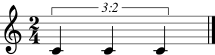

In [39]:
n = note.Note()
n.duration = duration.Duration(2.0/3.0)
n.duration.tuplets[0].tupletNormalShow = 'number'
s = stream.Stream()
s.repeatAppend(n, 3)
s.insert(0, meter.TimeSignature('2/4'))
s.show()

We can also set it to "type" or "both" to add the note shape to the bracket, but unfortunately, no MusicXML client yet supports this display on input or output.

Now we're ready to return to the `Duration` class.  Since the `.tuplets` property returns a tuple (appropriately enough), it's not something that can be manipulated directly.  To add a tuplet to an existing duration, use the `.appendTuplet(t)` method:

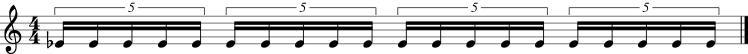

In [47]:
t = duration.Tuplet(5, 4)
t.setDurationType('16th')
d = duration.Duration('16th')
d.appendTuplet(t)
n = note.Note('E-4')
n.duration = d
s = stream.Stream()
s.repeatAppend(n, 20)
s.show()

Once a `Tuplet` is appended to a `Duration`, it becomes "frozen" and no further changes to its duration can be set (though its `.type` and display styles can still be changed).  This is to prevent changes to the duration that won't be reflected in the `Duration` object: 

In [48]:
t.frozen

True

Nested tuplets can be created by adding more than one tuplet to the duration:

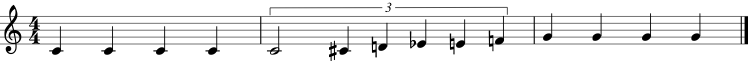

In [57]:
import copy
s = stream.Stream()
s.repeatAppend(note.Note(), 4)

t32h = duration.Tuplet(3, 2, 'half')
t54q = duration.Tuplet(5, 4, 'quarter')
n1 = note.Note()
n1.duration.type = 'half'
n1.duration.appendTuplet(copy.deepcopy(t32h))
s.append(n1)
for i in range(5):
    n = note.Note(61 + i)
    n.duration.type = 'quarter'
    n.duration.appendTuplet(copy.deepcopy(t32h))
    n.duration.appendTuplet(copy.deepcopy(t54q))
    s.append(n)
s.notes[4].duration.tuplets[0].type = 'start'
s.notes[5].duration.tuplets[1].type = 'start'
s.notes[-1].duration.tuplets[0].type = 'stop'
s.notes[-1].duration.tuplets[1].type = 'stop'
s.repeatAppend(note.Note('G4'), 4)
s.show()

For nested tuplets, it's important to explicitly state where tuplet brackets start and stop. As you can see from the output, MusicXML rendering of Nested tuplets is still hard for our partners at MuseScore which generated the image above (Finale renders a --5-- bracket around the five quarter notes.  However, MIDI rendering is correct:

In [58]:
s.show('midi')

There are sometimes `Durations` that can't be expressed easily
as a single written `Note` on a page.  For instance, a `Note`
lasting a half-note plus a sixteenth-note can't be written as
a single `Note` graphic, but it's perfectly fine to use as a
quarterLength.

In [23]:
oddDuration = duration.Duration()
oddDuration.quarterLength = 2.25

The `type` for these odd values is called "complex":

In [24]:
oddDuration.type

'complex'

Complex types have multiple "DurationTuple" objects in `.components` that represent the smaller, simple durations that make up the entire Duration:

In [25]:
oddDuration.components

(DurationTuple(type='half', dots=0, quarterLength=2.0),
 DurationTuple(type='16th', dots=0, quarterLength=0.25))

Some durations have multiple components even though they might not need them:

In [26]:
d = duration.Duration(1.0)
d.addDurationTuple(duration.DurationTuple('eighth', 0, 0.5))
d.components

(DurationTuple(type='quarter', dots=0, quarterLength=1.0),
 DurationTuple(type='eighth', dots=0, quarterLength=0.5))

In [27]:
d.type

'complex'

For these durations, there's a method called `.consolidate()` that will put both of these components together into one component.  In this case, it's a nice dotted quarter note:

In [28]:
d.consolidate()
(d.type, d.dots, d.quarterLength)

('quarter', 1, 1.5)

In [29]:
d.components

(DurationTuple(type='quarter', dots=1, quarterLength=1.5),)

However, forcing something that really should have multiple components into one creates an "inexpressible" type that can't be outputted to most formats:

In [30]:
d = duration.Duration(5.0)
d.consolidate()
d.type

'inexpressible'

In [31]:
d.components

(DurationTuple(type='inexpressible', dots=0, quarterLength=5.0),)

To fix this situation, the easiest thing to do is just to assign the duration its own quarterLength.

In [32]:
d.quarterLength = d.quarterLength
d.components

(DurationTuple(type='whole', dots=0, quarterLength=4.0),
 DurationTuple(type='quarter', dots=0, quarterLength=1.0))

There's one more strange `type` called "zero" for
Durations that don't have any Duration at all.  It's
used for measuring the conceptual length of grace notes,
spaceless objects like `Clefs`, Liz Taylor's marriages,
etc.:

In [33]:
k = key.KeySignature(3)
k.duration

<music21.duration.Duration 0.0>

In [34]:
k.duration.type

'zero'